# Preparing the dataset

### File path configuration

In [1]:
dataset_path = 'dataset.json'
batch_dataset_path = 'batch_dataset.json'

## Installing requirements

In [2]:
!pip install huggingface_hub
!pip install datasets
!pip install scikit-learn
!pip install matplotlib

from pathlib import Path
from huggingface_hub import notebook_login
import datasets
import warnings
from tqdm import tqdm, TqdmWarning
warnings.filterwarnings('ignore', category = TqdmWarning)
import numpy as np
import pandas as pd
import json
from sklearn.feature_extraction.text import CountVectorizer
import random
import matplotlib.pyplot as plt
import matplotlib.colors as colors

You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


## Downloading the dataset

In [3]:
if Path(dataset_path).exists() :
    dataset = pd.read_json(dataset_path) # Load from file if it already exists.
else :
    # Enter Hugging Face access token here.
    notebook_login()
    hugging_face_dataset = datasets.load_dataset('lmsys/chatbot_arena_conversations')
    dataset = hugging_face_dataset['train'].to_pandas()
    dataset.to_json(dataset_path)

In [4]:
# This cell is to visualise a row of the dataset for the report.
dataset[33:34]

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,turn,anony,language,tstamp,openai_moderation,toxic_chat_tag
33,8120899314f74641b09c2aa114d4d253,alpaca-13b,vicuna-13b,model_b,arena_user_316,[{'content': 'Salut ! Comment ça va ce matin ?...,[{'content': 'Salut ! Comment ça va ce matin ?...,6,True,French,1.682354e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil..."


In [5]:
# This cell is to visualise a typical `conversation_a` for the report.
dataset['conversation_a'][33]

array([{'content': 'Salut ! Comment ça va ce matin ?', 'role': 'user'},
       {'content': 'Ça va bien, merci. Et toi ?', 'role': 'assistant'},
       {'content': 'Ça va et toi ?', 'role': 'user'},
       {'content': 'Oui, et toi ?', 'role': 'assistant'},
       {'content': 'Ça va et vous ?', 'role': 'user'},
       {'content': 'Oui, et vous ?', 'role': 'assistant'},
       {'content': 'ça va', 'role': 'user'},
       {'content': 'ça va', 'role': 'assistant'},
       {'content': 'non ça va', 'role': 'user'},
       {'content': 'non ça va', 'role': 'assistant'},
       {'content': 'Ok ', 'role': 'user'},
       {'content': 'Ok', 'role': 'assistant'}], dtype=object)

In [6]:
# This cell is to visualise a typical `conversation_b` for the report.
dataset['conversation_b'][33]

array([{'content': 'Salut ! Comment ça va ce matin ?', 'role': 'user'},
       {'content': "Salut ! Je vais bien, merci. Comment allez-vous aujourd'hui ?", 'role': 'assistant'},
       {'content': 'Ça va et toi ?', 'role': 'user'},
       {'content': 'Oui, je vais bien également. Comment ça se passe pour vous ?', 'role': 'assistant'},
       {'content': 'Ça va et vous ?', 'role': 'user'},
       {'content': "Oui, je vais bien merci. Comment ça se passe pour vous aujourd'hui ?", 'role': 'assistant'},
       {'content': 'ça va', 'role': 'user'},
       {'content': "C'est super. Y a-t-il quelque chose que je puisse faire pour vous aider aujourd'hui ?", 'role': 'assistant'},
       {'content': 'non ça va', 'role': 'user'},
       {'content': "Très bien, si vous avez besoin de quelque chose, n'hésitez pas à me demander. Je suis là pour vous aider.", 'role': 'assistant'},
       {'content': 'Ok ', 'role': 'user'},
       {'content': "Très bien. N'hésitez pas à me contacter si vous avez besoi

In [7]:
# This cell is to visualise the share of languages across all messages.
languages = []
for i in range(dataset.shape[0]) :
    languages += [dataset['language'][i]] * (dataset['turn'][i] * 3) # Some conversations last more than one turn, and each turn is a human message followed by a message from each model.
language, count = np.unique(languages, return_counts = True)
sorted_count = np.argsort(count)[::-1]

print('Out of ' + str(len(languages)) + ' messages:')
for i in range(len(count)) :
    print(language[sorted_count[i]] + ': ' + str(count[sorted_count[i]]))

Out of 117948 messages:
English: 103569
German: 2400
Spanish: 2184
French: 1626
unknown: 1377
Portuguese: 1041
Russian: 990
Italian: 486
Chinese: 480
Dutch: 306
Polish: 300
Japanese: 297
Finnish: 183
Korean: 174
Danish: 168
Latin: 132
Vietnamese: 117
Turkish: 117
Indonesian: 111
Czech: 108
Ukrainian: 105
Scots: 99
Swedish: 87
Slovak: 84
Hebrew: 81
Romanian: 75
Arabic: 69
Hungarian: 69
Norwegian: 60
Slovenian: 57
Persian: 57
Galician: 54
Greek: 48
Esperanto: 45
Thai: 42
Catalan: 39
Luxembourgish: 39
Waray: 33
Hawaiian: 30
Bislama: 30
Uzbek: 30
Afrikaans: 27
Bulgarian: 27
Norwegian Nynorsk: 27
Tsonga: 24
Maltese: 21
Icelandic: 21
Serbian: 21
Malay: 18
Quechua: 15
Ganda: 15
Southern Sotho: 15
Corsican: 15
Tigrinya: 15
Xhosa: 12
Akan: 12
Interlingua: 12
Kinyarwanda: 12
Sanskrit: 12
Macedonian: 12
Faroese: 12
Estonian: 12
Haitian Creole: 9
Fijian: 9
Aymara: 9
Latvian: 9
Afar: 9
Welsh: 9
Tswana: 9
Hindi: 9
Maori: 9
Occitan: 9
Somali: 6
Oromo: 6
Wolof: 6
Volapük: 6
Swahili: 6
Croatian: 6
Shon

## Extracting text-author pairs

In [8]:
text_author_pairs = []

for _, row in dataset.iterrows():
    # Process messages from `model_a`.
    for message in row['conversation_a']:
        if message['role'] == 'assistant':
            text_author_pairs.append({
                'text': message['content'],
                'author': row['model_a']
            })
        else :
            # Process messages from a human.
            text_author_pairs.append({
                'text': message['content'],
                'author': row['judge']
            })

    # Process messages from `model_b`.
    for message in row['conversation_b']:
        if message['role'] == 'assistant':
            text_author_pairs.append({
                'text': message['content'],
                'author': row['model_b']
            })

random.seed(0)
random.shuffle(text_author_pairs)

In [9]:
# This cell is to visualise the share of authorship across all messages.
authors = [entry['author'] for entry in text_author_pairs]
author, count = np.unique(authors, return_counts = True)
sorted_count = np.argsort(count)[::-1]

i = 0
while count[sorted_count[i]] >= 150 :
    print(author[sorted_count[i]] + ': ' + str(count[sorted_count[i]]))
    i += 1
    
for k in [50, 25, 15, 10, 6, 3, 1] :
    j = i
    while i < len(count) :
        if count[sorted_count[i]] < k :
            break
        i += 1
    print(str(i - j) + ' authors who have between ' + str(k) + ' and ' + str(count[sorted_count[j]]) + ' texts.')

vicuna-13b: 7193
koala-13b: 6615
oasst-pythia-12b: 5774
gpt-3.5-turbo: 5573
alpaca-13b: 5399
gpt-4: 4945
claude-v1: 4500
RWKV-4-Raven-14B: 4392
chatglm-6b: 3791
fastchat-t5-3b: 3699
vicuna-7b: 3578
palm-2: 3527
mpt-7b-chat: 3516
dolly-v2-12b: 3307
stablelm-tuned-alpha-7b: 3249
claude-instant-v1: 3117
llama-13b: 2393
gpt4all-13b-snoozy: 1425
wizardlm-13b: 1391
guanaco-33b: 1248
arena_user_15085: 458
arena_user_9965: 434
arena_user_13046: 385
arena_user_257: 296
arena_user_11473: 240
arena_user_3820: 213
arena_user_9676: 166
52 authors who have between 50 and 138 texts.
91 authors who have between 25 and 49 texts.
172 authors who have between 15 and 24 texts.
252 authors who have between 10 and 14 texts.
619 authors who have between 6 and 9 texts.
1877 authors who have between 3 and 5 texts.
10313 authors who have between 1 and 2 texts.


## Creating and batching token count vectors from text

In [10]:
# Extract texts and their authors.
texts = [entry['text'] for entry in text_author_pairs]
authors = ['human' if 'arena_user_' in entry['author'] else entry['author'] for entry in text_author_pairs]

# Turn individual texts into vectors.
vectoriser = CountVectorizer()
text_vectors = vectoriser.fit_transform(texts)

# Allocate quotas for each batch.
batch_count = {} 
for author in list(set(authors)) :
    # Find out how many batches of 200 texts are needed.
    number_of_batches = round(authors.count(author) / 200)
    for i in range(number_of_batches) :
        # Distribute the remainder/shortfall evenly.
        batch_count[str(i) + '_' + author] = np.floor((i + 1) * authors.count(author) / number_of_batches)
        for j in range(i) :
            # Subtract the count of previous batches.
            batch_count[str(i) + '_' + author] -= batch_count[str(j) + '_' + author]
        
print('Populating batches...')
batch_vectors = {}
batch_quota = batch_count.copy()
for i, author in enumerate(tqdm(authors)):
    batch_to_insert = [name for name in batch_quota if author in name and batch_quota[name] > 0][0]
    if batch_to_insert in batch_vectors:
        # The resulting vectors represent the number of times each token appears in that author's entire corpus.
        batch_vectors[batch_to_insert] += text_vectors[i].toarray()
    else:
        # Add this new batch to the list.
        batch_vectors[batch_to_insert] = text_vectors[i].toarray()
    batch_quota[batch_to_insert] -= 1

# Convert into a DataFrame.
print('Converting into DataFrame...')
batch_dataset = pd.DataFrame({name: vector.flatten() for name, vector in tqdm(batch_vectors.items())}, index = vectoriser.get_feature_names_out())

batch_dataset

Populating batches...


100%|████████████████████████████████████████████████████████████████████████| 117948/117948 [01:11<00:00, 1652.31it/s]


Converting into DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 591/591 [00:00<00:00, 2999.33it/s]


,0_human,0_claude-instant-v1,0_RWKV-4-Raven-14B,0_oasst-pythia-12b,0_chatglm-6b,0_palm-2,0_dolly-v2-12b,0_koala-13b,0_wizardlm-13b,0_alpaca-13b,...,190_human,28_oasst-pythia-12b,191_human,32_koala-13b,192_human,35_vicuna-13b,193_human,194_human,195_human,196_human
00,1,0,0,2,0,7,0,2,3,0,...,2,0,0,0,1,0,0,10,1,50
000,0,12,4,6,0,8,1,6,5,3,...,11,2,0,8,0,5,3,0,0,0
0000,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｔｏ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ｗｅｅｋｓ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
𝘀𝗶𝗺𝗽𝗹𝗲,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# This cell is to visualise the amount of batches attributed to each author.
batch_count_per_author = {}
for author in list(set(authors)):
    batches_for_author = [batch_count[batch] for batch in batch_count if batch.split('_')[1] == author]
    batch_count_per_author[author] = [len(batches_for_author), sum(batches_for_author) / len(batches_for_author)]
sorted_count = np.argsort([batch_count_per_author[author][0] for author in batch_count_per_author])[::-1]
for author in sorted_count :
    print(str(list(batch_count_per_author.values())[author][0]) + ' batches of ' + list(batch_count_per_author.keys())[author] + ' with an average of ' + '{0:.2f}'.format(list(batch_count_per_author.values())[author][1]) + ' texts per batch.')

197 batches of human with an average of 199.57 texts per batch.
36 batches of vicuna-13b with an average of 199.81 texts per batch.
33 batches of koala-13b with an average of 200.45 texts per batch.
29 batches of oasst-pythia-12b with an average of 199.10 texts per batch.
28 batches of gpt-3.5-turbo with an average of 199.04 texts per batch.
27 batches of alpaca-13b with an average of 199.96 texts per batch.
25 batches of gpt-4 with an average of 197.80 texts per batch.
22 batches of claude-v1 with an average of 204.55 texts per batch.
22 batches of RWKV-4-Raven-14B with an average of 199.64 texts per batch.
19 batches of chatglm-6b with an average of 199.53 texts per batch.
18 batches of vicuna-7b with an average of 198.78 texts per batch.
18 batches of mpt-7b-chat with an average of 195.33 texts per batch.
18 batches of fastchat-t5-3b with an average of 205.50 texts per batch.
18 batches of palm-2 with an average of 195.94 texts per batch.
17 batches of dolly-v2-12b with an average o

### Normalisation

In [12]:
# Find the average text length of each author. 
batch_average_length = {name: np.sum(vector) / batch_count[name] for name, vector in batch_vectors.items()}

# Normalise the length of each corpus.
print('Normalising...')
for name in tqdm(batch_vectors) :
    batch_dataset[name] /= np.sum(batch_vectors[name])
    
# Since it has been lost, add the average text length as a separate feature.
batch_dataset = pd.concat([batch_dataset, pd.DataFrame(batch_average_length, index = [' length'])])

batch_dataset

Normalising...


100%|████████████████████████████████████████████████████████████████████████████████| 591/591 [01:09<00:00,  8.52it/s]


,0_human,0_claude-instant-v1,0_RWKV-4-Raven-14B,0_oasst-pythia-12b,0_chatglm-6b,0_palm-2,0_dolly-v2-12b,0_koala-13b,0_wizardlm-13b,0_alpaca-13b,...,190_human,28_oasst-pythia-12b,191_human,32_koala-13b,192_human,35_vicuna-13b,193_human,194_human,195_human,196_human
00,0.000184,0.000000,0.000000,0.000102,0.000000,0.000252,0.000000,0.000071,0.000125,0.000000,...,0.000289,0.000000,0.000,0.000000,0.000197,0.000000,0.000000,0.001566,0.000163,0.00959
000,0.000000,0.000431,0.000191,0.000306,0.000000,0.000288,0.000088,0.000214,0.000208,0.000322,...,0.001589,0.000109,0.000,0.000301,0.000000,0.000197,0.000513,0.000000,0.000000,0.00000
0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000036,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｗｅｅｋｓ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
𝘀𝗶𝗺𝗽𝗹𝗲,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻𝘀,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


### Saving a checkpoint of the dataset

In [13]:
# Nowhere is this checkpoint loaded, so there is no point in doing this.
#batch_dataset.to_json(batch_dataset_path)

# Visualising a single run

## Custom holdout

In [14]:
def holdout(df, authors, seed) :
    """
    Splits the dataset into training and holdout sets by randomly selecting one batch per author for holdout.
    Args:
        df (pd.DataFrame): Input dataset with columns as batches and rows as features.
        authors (list): List of unique author identifiers present in batch names.
        seed (int): Initialises `random` with seed for reproducibility.

    Returns:
        (pd.DataFrame): Training dataset.
        (pd.DataFrame): Holdout dataset.
    """
    random.seed(seed)
    
    holdout_list = []
    for author in authors :
        batch = df[random.choice([batch for batch in df.columns if author in batch])].copy()
        holdout_list.append(batch)

    holdout_df = pd.concat(holdout_list, axis = 1)
    training_df = df.drop(columns = holdout_df.columns).copy()
    return training_df, holdout_df

# Use the function for this seed 0 run.
training_dataset, holdout_dataset = holdout(batch_dataset, list(set(authors)), 0)
training_dataset

,0_human,0_claude-instant-v1,0_RWKV-4-Raven-14B,0_oasst-pythia-12b,0_chatglm-6b,0_palm-2,0_dolly-v2-12b,0_koala-13b,0_alpaca-13b,0_fastchat-t5-3b,...,190_human,28_oasst-pythia-12b,191_human,32_koala-13b,192_human,35_vicuna-13b,193_human,194_human,195_human,196_human
00,0.000184,0.000000,0.000000,0.000102,0.000000,0.000252,0.000000,0.000071,0.000000,0.000439,...,0.000289,0.000000,0.000,0.000000,0.000197,0.000000,0.000000,0.001566,0.000163,0.00959
000,0.000000,0.000431,0.000191,0.000306,0.000000,0.000288,0.000088,0.000214,0.000322,0.000044,...,0.001589,0.000109,0.000,0.000301,0.000000,0.000197,0.000513,0.000000,0.000000,0.00000
0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000036,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｗｅｅｋｓ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
𝘀𝗶𝗺𝗽𝗹𝗲,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻𝘀,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


## Feature selection

In [15]:
# This cell is to visualise the amount of tokens that are shared between some number of LLM batches.
llm_dataset = training_dataset[[name for name in training_dataset.columns if not 'human' in name]].copy()

print('Of ' + str(llm_dataset.shape[0]) + ' tokens:')
i = 1
while i <= llm_dataset.shape[1] :
    print(str(llm_dataset[llm_dataset.ne(0).sum(axis = 1) >= i].shape[0]) + ' of them appear at least once in ' + str(i) + ' or more LLM batches.')
    i *= 2
print(str(llm_dataset[llm_dataset.ne(0).sum(axis = 1) == llm_dataset.shape[1]].shape[0]) + ' of them appear at least once in all ' + str(llm_dataset.shape[1]) + ' LLM batches.')

Of 195412 tokens:
177432 of them appear at least once in 1 or more LLM batches.
77869 of them appear at least once in 2 or more LLM batches.
42947 of them appear at least once in 4 or more LLM batches.
25942 of them appear at least once in 8 or more LLM batches.
16200 of them appear at least once in 16 or more LLM batches.
10155 of them appear at least once in 32 or more LLM batches.
6177 of them appear at least once in 64 or more LLM batches.
3423 of them appear at least once in 128 or more LLM batches.
1367 of them appear at least once in 256 or more LLM batches.
131 of them appear at least once in all 374 LLM batches.


In [16]:
def common_tokens(dataset, holdout_dataset) :
    """
    Filters the dataset to retain only tokens that appear in every LLM training batch.
    Args:
        dataset (pd.DataFrame): Training dataset with features as rows and batches as columns.
        holdout_dataset (pd.DataFrame): Holdout dataset, structured similarly.
        
    Returns:
        (pd.DataFrame): Updated training dataset.
        (pd.DataFrame): Updated holdout dataset.
    """
    human_dataset = dataset[[name for name in dataset.columns if 'human' in name]].copy()
    llm_dataset = dataset[[name for name in dataset.columns if not 'human' in name]].copy()
    dataset = pd.merge(llm_dataset[llm_dataset.ne(0).sum(axis = 1) == llm_dataset.shape[1]], human_dataset, left_index = True, right_index = True, validate = '1:1')
    holdout_dataset = holdout_dataset.loc[dataset.index].copy()
    return dataset, holdout_dataset

# Use the function for this seed 0 run.
training_dataset, holdout_dataset = common_tokens(training_dataset, holdout_dataset)
training_dataset

,0_claude-instant-v1,0_RWKV-4-Raven-14B,0_oasst-pythia-12b,0_chatglm-6b,0_palm-2,0_dolly-v2-12b,0_koala-13b,0_alpaca-13b,0_fastchat-t5-3b,0_vicuna-13b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
10,0.000754,0.001286,0.000714,0.000946,0.001117,0.001150,0.000892,0.001396,0.001493,0.000419,...,0.001738,0.004165,0.003317,0.001445,0.003271,0.001777,0.002565,0.002035,0.001960,0.002877
about,0.001184,0.001572,0.001479,0.002137,0.002343,0.001769,0.001926,0.001396,0.001669,0.001468,...,0.004344,0.003597,0.002211,0.003612,0.002249,0.006122,0.003248,0.003758,0.003431,0.002110
all,0.001722,0.001762,0.001020,0.001086,0.002379,0.002477,0.001498,0.001611,0.001361,0.001342,...,0.000869,0.001325,0.001474,0.003034,0.002045,0.001382,0.003248,0.001879,0.001307,0.001726
also,0.000825,0.002905,0.001887,0.002943,0.003713,0.002742,0.002069,0.003652,0.002503,0.002139,...,0.000217,0.000379,0.000921,0.001011,0.000613,0.000790,0.000171,0.000313,0.000163,0.001343
am,0.000144,0.001143,0.001020,0.000315,0.002631,0.000619,0.000499,0.000967,0.000878,0.000839,...,0.000652,0.000757,0.000921,0.001156,0.000204,0.001185,0.000513,0.000313,0.001960,0.000959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
world,0.000861,0.000857,0.001275,0.001576,0.001550,0.001769,0.001249,0.002148,0.000703,0.001300,...,0.001738,0.001515,0.000921,0.000578,0.001431,0.000197,0.000513,0.000939,0.000327,0.001151
would,0.002261,0.001286,0.001683,0.001436,0.001586,0.003892,0.001463,0.003545,0.000878,0.002013,...,0.001520,0.001325,0.001658,0.002167,0.001840,0.001975,0.001710,0.002349,0.001634,0.001726
you,0.007176,0.012717,0.011829,0.010054,0.015392,0.009112,0.010417,0.012675,0.008255,0.008514,...,0.014553,0.013063,0.011056,0.011415,0.008383,0.015403,0.017268,0.012995,0.014540,0.009973
your,0.002942,0.007811,0.004640,0.006551,0.007209,0.002212,0.005708,0.005908,0.004128,0.004194,...,0.002824,0.002651,0.004422,0.003323,0.001227,0.005332,0.005471,0.005636,0.002451,0.002493


## Centring

In [17]:
def centre(dataset, holdout_dataset) :
    """
    Centres the dataset by subtracting the mean of each feature.

    Args:
        dataset (pd.DataFrame): Training dataset with features as rows and batches as columns.
        holdout_dataset (pd.DataFrame): Holdout dataset, structured similarly.

    Returns:
        (pd.DataFrame): Updated training dataset.
        (pd.DataFrame): Updated holdout dataset.
    """
    features_mean = pd.Series({feature: np.mean(dataset.loc[feature]) for feature in dataset.index})
    for batch in dataset.columns :
        dataset[batch] -= features_mean
    for batch in holdout_dataset.columns :
        holdout_dataset[batch] -= features_mean
    return dataset, holdout_dataset

# Use the function for this seed 0 run.    
training_dataset, holdout_dataset = centre(training_dataset, holdout_dataset)
training_dataset[training_dataset.index == ' length']

,0_claude-instant-v1,0_RWKV-4-Raven-14B,0_oasst-pythia-12b,0_chatglm-6b,0_palm-2,0_dolly-v2-12b,0_koala-13b,0_alpaca-13b,0_fastchat-t5-3b,0_vicuna-13b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
length,61.092754,22.945652,15.995903,60.890376,59.704781,-24.293844,57.598114,-35.777966,28.525919,37.25721,...,-59.426207,-56.151886,-55.290529,-47.956886,-58.106886,-57.114649,-53.316886,-50.466408,-51.956886,-56.491886


## Standardisation

In [18]:
def standardise(dataset, holdout_dataset) :
    """
    Standardises the dataset by dividing each feature by its standard deviation.

    Args:
        dataset (pd.DataFrame): Training dataset with features as rows and batches as columns.
        holdout_dataset (pd.DataFrame): Holdout dataset, structured similarly.

    Returns:
        (pd.DataFrame): Updated training dataset.
        (pd.DataFrame): Updated holdout dataset.
    """
    features_std = pd.Series({feature: np.std(dataset.loc[feature]) for feature in dataset.index})
    for batch in dataset.columns :
        dataset[batch] /= features_std
    for batch in holdout_dataset.columns :
        holdout_dataset[batch] /= features_std
    return dataset, holdout_dataset

# Use the function for this seed 0 run.    
training_dataset, holdout_dataset = standardise(training_dataset, holdout_dataset)
training_dataset[training_dataset.index == ' length']

,0_claude-instant-v1,0_RWKV-4-Raven-14B,0_oasst-pythia-12b,0_chatglm-6b,0_palm-2,0_dolly-v2-12b,0_koala-13b,0_alpaca-13b,0_fastchat-t5-3b,0_vicuna-13b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
length,1.303194,0.489463,0.341215,1.298877,1.273587,-0.518222,1.228649,-0.763194,0.608498,0.794749,...,-1.267645,-1.197799,-1.179425,-1.022988,-1.239502,-1.218336,-1.137324,-1.076519,-1.108313,-1.205051


C:\Users\Homeworkace\AppData\Local\Temp\ipykernel_25380\891403907.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  feature_graph_figure.show()


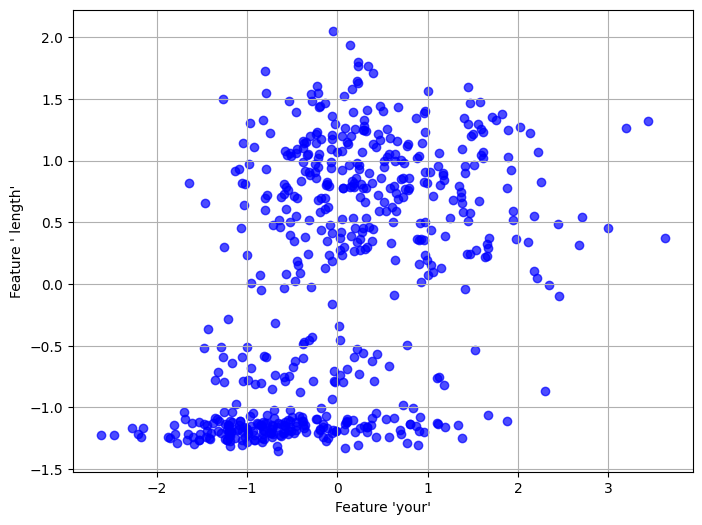

In [19]:
# This cell is to verify that the batches show discernible spread and that features have roughly the same scale. 
x_token = training_dataset.index[-2]
y_token = training_dataset.index[-1]

feature_graph_figure = plt.figure(figsize = (8, 6))
feature_graph = feature_graph_figure.subplots()
feature_graph.scatter(training_dataset.loc[x_token], training_dataset.loc[y_token], color = 'blue', alpha = 0.7)
feature_graph.set_xlabel('Feature \'' + x_token + '\'')
feature_graph.set_ylabel('Feature \'' + y_token + '\'')
feature_graph.grid(True)
feature_graph_figure.show()

## Power iteration

In [20]:
def power_iteration(A, num_iter, tol, single_run_diagnostics = False):
    """
    Computes the dominant eigenvalue and corresponding eigenvector of matrix A.
    Args:
        A (np.ndarray): Input symmetric matrix.
        num_iter (int): Number of iterations.
        tol (float): Tolerance for convergence.
        single_run_diagnostics (bool): If True, shows a progress bar to convergence.

    Returns:
        (np.ndarray): Approximation of the largest eigenvector.
        (float): Corresponding eigenvalue.
    """
    # Start with a random unit vector.
    b = np.random.rand(A.shape[1])
    b = b / np.linalg.norm(b)

    # Start a progress bar.
    if single_run_diagnostics :
        error_meter = tqdm(position = 0, total = 7, bar_format='{bar} | {postfix}')
        
    for i in range(num_iter):
        b_next = A @ b # Multiply, and...
        b_next = b_next / np.linalg.norm(b_next) # ... normalise!
        
        # Convergence is when the candidate vector moves too little.
        error = np.linalg.norm(b_next - b)
        b = b_next
        if single_run_diagnostics :
            error_meter.update(min(-np.log10(error), error_meter.total) - error_meter.n)
            error_meter.set_postfix_str('{:.2E}'.format(error) + ' of error after ' + str(i + 1) + ' iterations...')
        if error < tol:
            if single_run_diagnostics :
                error_meter.close()
            break

    eigenvalue = b.T @ A @ b  # Rayleigh quotient.
    return b, eigenvalue

## Principal component analysis

In [21]:
def pca_power_iteration(data, num_components, num_iter, single_run_diagnostics = False):
    """
    Principal component analysis with power iteration to compute the principal components.
    Args:
        data (np.ndarray): Input data matrix (rows are samples, columns are features).
        num_components (int): Number of principal components to compute.
        num_iter (int): Number of iterations for power iteration.
        single_run_diagnostics (bool): Passes value to power_iteration(). If True, prints whenever a new component is being calculated.

    Returns:
        (list): List of principal components (eigenvectors).
        (list): List of corresponding eigenvalues.
    """
    components = []
    explained_variance = []
    
    # Compute covariance matrix.
    n = data.shape[1]
    covariance_matrix = (data @ data.T) / n

    for i in range(num_components):
        # Compute the largest eigenvector using power iteration.
        if single_run_diagnostics :
            print('Computing PC' + str(i + 1) + '...')
        eigenvector, eigenvalue = power_iteration(covariance_matrix, num_iter, 1e-7, single_run_diagnostics)
        components.append(eigenvector)
        explained_variance.append(eigenvalue)
        
        # Deflate the covariance matrix.
        covariance_matrix -= eigenvalue * np.outer(eigenvector, eigenvector)
        if np.linalg.norm(covariance_matrix, ord = 'fro') < 1e-10 :
            if single_run_diagnostics :
                print('Stopped as all variance has been extracted after computing ' + str(i + 1) + ' PCs.')
            break
        
    return components, explained_variance

### Using PCA in this run

In [22]:
components, explained_variance = pca_power_iteration(training_dataset, 50, 2000, True)

Computing PC1...


██████████████████████████████████████████████████████████████████████████ | , 3.82E-08 of error after 15 iterations...


Computing PC2...


██████████████████████████████████████████████████████████████████████████ | , 7.43E-08 of error after 49 iterations...


Computing PC3...


██████████████████████████████████████████████████████████████████████████ | , 9.66E-08 of error after 33 iterations...


Computing PC4...


██████████████████████████████████████████████████████████████████████████ | , 8.02E-08 of error after 49 iterations...


Computing PC5...


█████████████████████████████████████████████████████████████████████████ | , 9.56E-08 of error after 130 iterations...


Computing PC6...


█████████████████████████████████████████████████████████████████████████ | , 9.76E-08 of error after 102 iterations...


Computing PC7...


█████████████████████████████████████████████████████████████████████████ | , 9.76E-08 of error after 161 iterations...


Computing PC8...


█████████████████████████████████████████████████████████████████████████ | , 9.85E-08 of error after 695 iterations...


Computing PC9...


█████████████████████████████████████████████████████████████████████████ | , 9.86E-08 of error after 534 iterations...


Computing PC10...


█████████████████████████████████████████████████████████████████████████ | , 9.84E-08 of error after 225 iterations...


Computing PC11...


█████████████████████████████████████████████████████████████████████████ | , 9.43E-08 of error after 194 iterations...


Computing PC12...


█████████████████████████████████████████████████████████████████████████ | , 9.96E-08 of error after 592 iterations...


Computing PC13...


████████████████████████████████████████████████▉                        | , 1.73E-05 of error after 2000 iterations...


Computing PC14...


████████████████████████████████████████████████████████████████████████ | , 9.94E-08 of error after 1410 iterations...


Computing PC15...


█████████████████████████████████████████████████████████████████████████ | , 9.52E-08 of error after 217 iterations...


Computing PC16...


█████████████████████████████████████████████████████████████████████████ | , 9.98E-08 of error after 759 iterations...


Computing PC17...


█████████████████████████████████████████████████████████████████████████ | , 9.83E-08 of error after 655 iterations...


Computing PC18...


█████████████████████████████████████████████████████████████████████████ | , 9.88E-08 of error after 469 iterations...


Computing PC19...


█████████████████████████████████████████████████████████████████████████ | , 9.77E-08 of error after 356 iterations...


Computing PC20...


█████████████████████████████████████████████████████████████████████████ | , 9.98E-08 of error after 767 iterations...


Computing PC21...


█████████████████████████████████████████████████████████████████████████ | , 9.77E-08 of error after 480 iterations...


Computing PC22...


█████████████████████████████████████████████████████████████████████████ | , 9.94E-08 of error after 329 iterations...


Computing PC23...


█████████████████████████████████████████████████████████████████████████ | , 9.79E-08 of error after 426 iterations...


Computing PC24...


█████████████████████████████████████████████████████████████████████████ | , 9.84E-08 of error after 418 iterations...


Computing PC25...


█████████████████████████████████████████████████████████████████████████ | , 9.90E-08 of error after 681 iterations...


Computing PC26...


█████████████████████████████████████████████████████████████████████████ | , 9.92E-08 of error after 664 iterations...


Computing PC27...


█████████████████████████████████████████████████████████████████████████ | , 9.89E-08 of error after 508 iterations...


Computing PC28...


█████████████████████████████████████████████████████████████████████████ | , 9.91E-08 of error after 548 iterations...


Computing PC29...


███████████████████████████████████████████████████████▊                 | , 3.74E-06 of error after 2000 iterations...


Computing PC30...


█████████████████████████████████████████████████████████████████████████ | , 9.91E-08 of error after 589 iterations...


Computing PC31...


████████████████████████████████████████████████████████████████████████ | , 9.96E-08 of error after 1138 iterations...


Computing PC32...


█████████████████████████████████████████████████████████████████████████ | , 9.86E-08 of error after 770 iterations...


Computing PC33...


█████████████████████████████████████████████████████████████████████████ | , 9.98E-08 of error after 294 iterations...


Computing PC34...


████████████████████████████████████████████████████████████████████████ | , 9.97E-08 of error after 1451 iterations...


Computing PC35...


█████████████████████████████████████████████████████████████████████████ | , 9.84E-08 of error after 470 iterations...


Computing PC36...


█████████████████████████████████████████████████████████████████████████ | , 9.82E-08 of error after 502 iterations...


Computing PC37...


█████████████████████████████████████████████████████████████████████████ | , 9.90E-08 of error after 803 iterations...


Computing PC38...


████████████████████████████████████████████████████████████████████████ | , 1.00E-07 of error after 1100 iterations...


Computing PC39...


█████████████████████████████████████████████████████████████████████████ | , 9.89E-08 of error after 656 iterations...


Computing PC40...


█████████████████████████████████████████████████████████▊               | , 2.41E-06 of error after 2000 iterations...


Computing PC41...


█████████████████████████████████████████████████████████████████████████ | , 9.87E-08 of error after 603 iterations...


Computing PC42...


█████████████████████████████████████████████████████████████████████████ | , 9.82E-08 of error after 539 iterations...


Computing PC43...


█████████████████████████████████████████████████████████████████████████ | , 9.86E-08 of error after 775 iterations...


Computing PC44...


█████████████████████████████████████████████████████████████████████████ | , 9.83E-08 of error after 502 iterations...


Computing PC45...


█████████████████████████████████████████████████████████████████████████ | , 9.94E-08 of error after 719 iterations...


Computing PC46...


████████████████████████████████████████████████████████████████████████ | , 9.99E-08 of error after 1614 iterations...


Computing PC47...


████████████████████████████████████████████████████████████████████████ | , 9.95E-08 of error after 1243 iterations...


Computing PC48...


█████████████████████████████████████████████████████████████████████████ | , 9.95E-08 of error after 490 iterations...


Computing PC49...


█████████████████████████████████████████████████████████████████████████ | , 9.89E-08 of error after 498 iterations...


Computing PC50...


█████████████████████████████████████████████████████████████████████████ | , 9.89E-08 of error after 936 iterations...


C:\Users\Homeworkace\AppData\Local\Temp\ipykernel_25380\1201320650.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  variance_graph_figure.show()


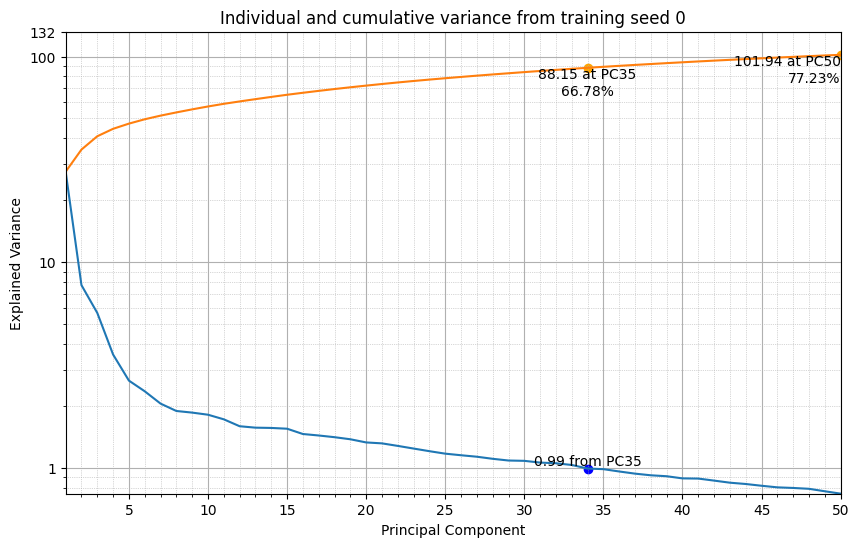

In [23]:
# This cell is to visualise the individual and cumulative variances of the components.
variance_graph_figure = plt.figure(figsize = (10, 6))
variance_graph = variance_graph_figure.subplots()
variance_graph.set_xticks(range(0, 51, 5))
variance_graph.set_xlim(1, 50)
variance_graph.set_yscale('log')
variance_graph.set_ylim(0.75, 132)
variance_graph.set_yticks([1, 10, 100, 132], labels=['1', '10', '100', '132'])
variance_graph.plot(range(1, 51), explained_variance)
variance_graph.plot(range(1, 51), [np.sum(explained_variance[:i]) for i in range(1, 51)])

# Threshold of Kaiser criterion.
kaiser_criterion = 0
while explained_variance[kaiser_criterion] > 1 :
    kaiser_criterion += 1
variance_graph.scatter(kaiser_criterion + 1, explained_variance[kaiser_criterion], color='blue')
variance_graph.annotate('{0:.2f}'.format(explained_variance[kaiser_criterion]) + ' from PC35' , (kaiser_criterion + 1, explained_variance[kaiser_criterion]), ha = 'center', va = 'bottom')
# Cumulative variance at Kaiser criterion.
variance_graph.scatter(kaiser_criterion + 1, np.sum(explained_variance[:kaiser_criterion + 1]), color='orange')
variance_graph.annotate('{0:.2f}'.format(np.sum(explained_variance[:kaiser_criterion + 1])) + ' at PC35\n' + '{0:.2f}'.format(np.sum(explained_variance[:kaiser_criterion + 1]) / 1.32) + '%', (kaiser_criterion + 1, np.sum(explained_variance[:kaiser_criterion + 1])), ha = 'center', va = 'top')
variance_graph.scatter(50, np.sum(explained_variance), color='orange')
variance_graph.annotate('{0:.2f}'.format(np.sum(explained_variance)) + ' at PC50\n' + '{0:.2f}'.format(np.sum(explained_variance[:50]) / 1.32) + '%', (50, np.sum(explained_variance[:50])), ha = 'right', va = 'top')

variance_graph.set_title('Individual and cumulative variance from training seed 0')
variance_graph.set_xlabel('Principal Component')
variance_graph.set_ylabel('Explained Variance')
variance_graph.grid(True)
variance_graph.minorticks_on()
variance_graph.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = 0.5)
variance_graph.grid(which = 'minor', axis = 'y', linestyle = ':', linewidth = 0.5)
variance_graph_figure.show()
variance_graph_figure.savefig('images/variance.png')

### Projecting into PC space

In [24]:
def transform_to_pc(batch, components) :
    pc_space_batch = []
    for component in components :
        pc_space_batch.append(np.dot(batch, component))
        
    return pc_space_batch

## Visualising PCA

C:\Users\Homeworkace\AppData\Local\Temp\ipykernel_25380\1640669588.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  feature_graph_figure.show()


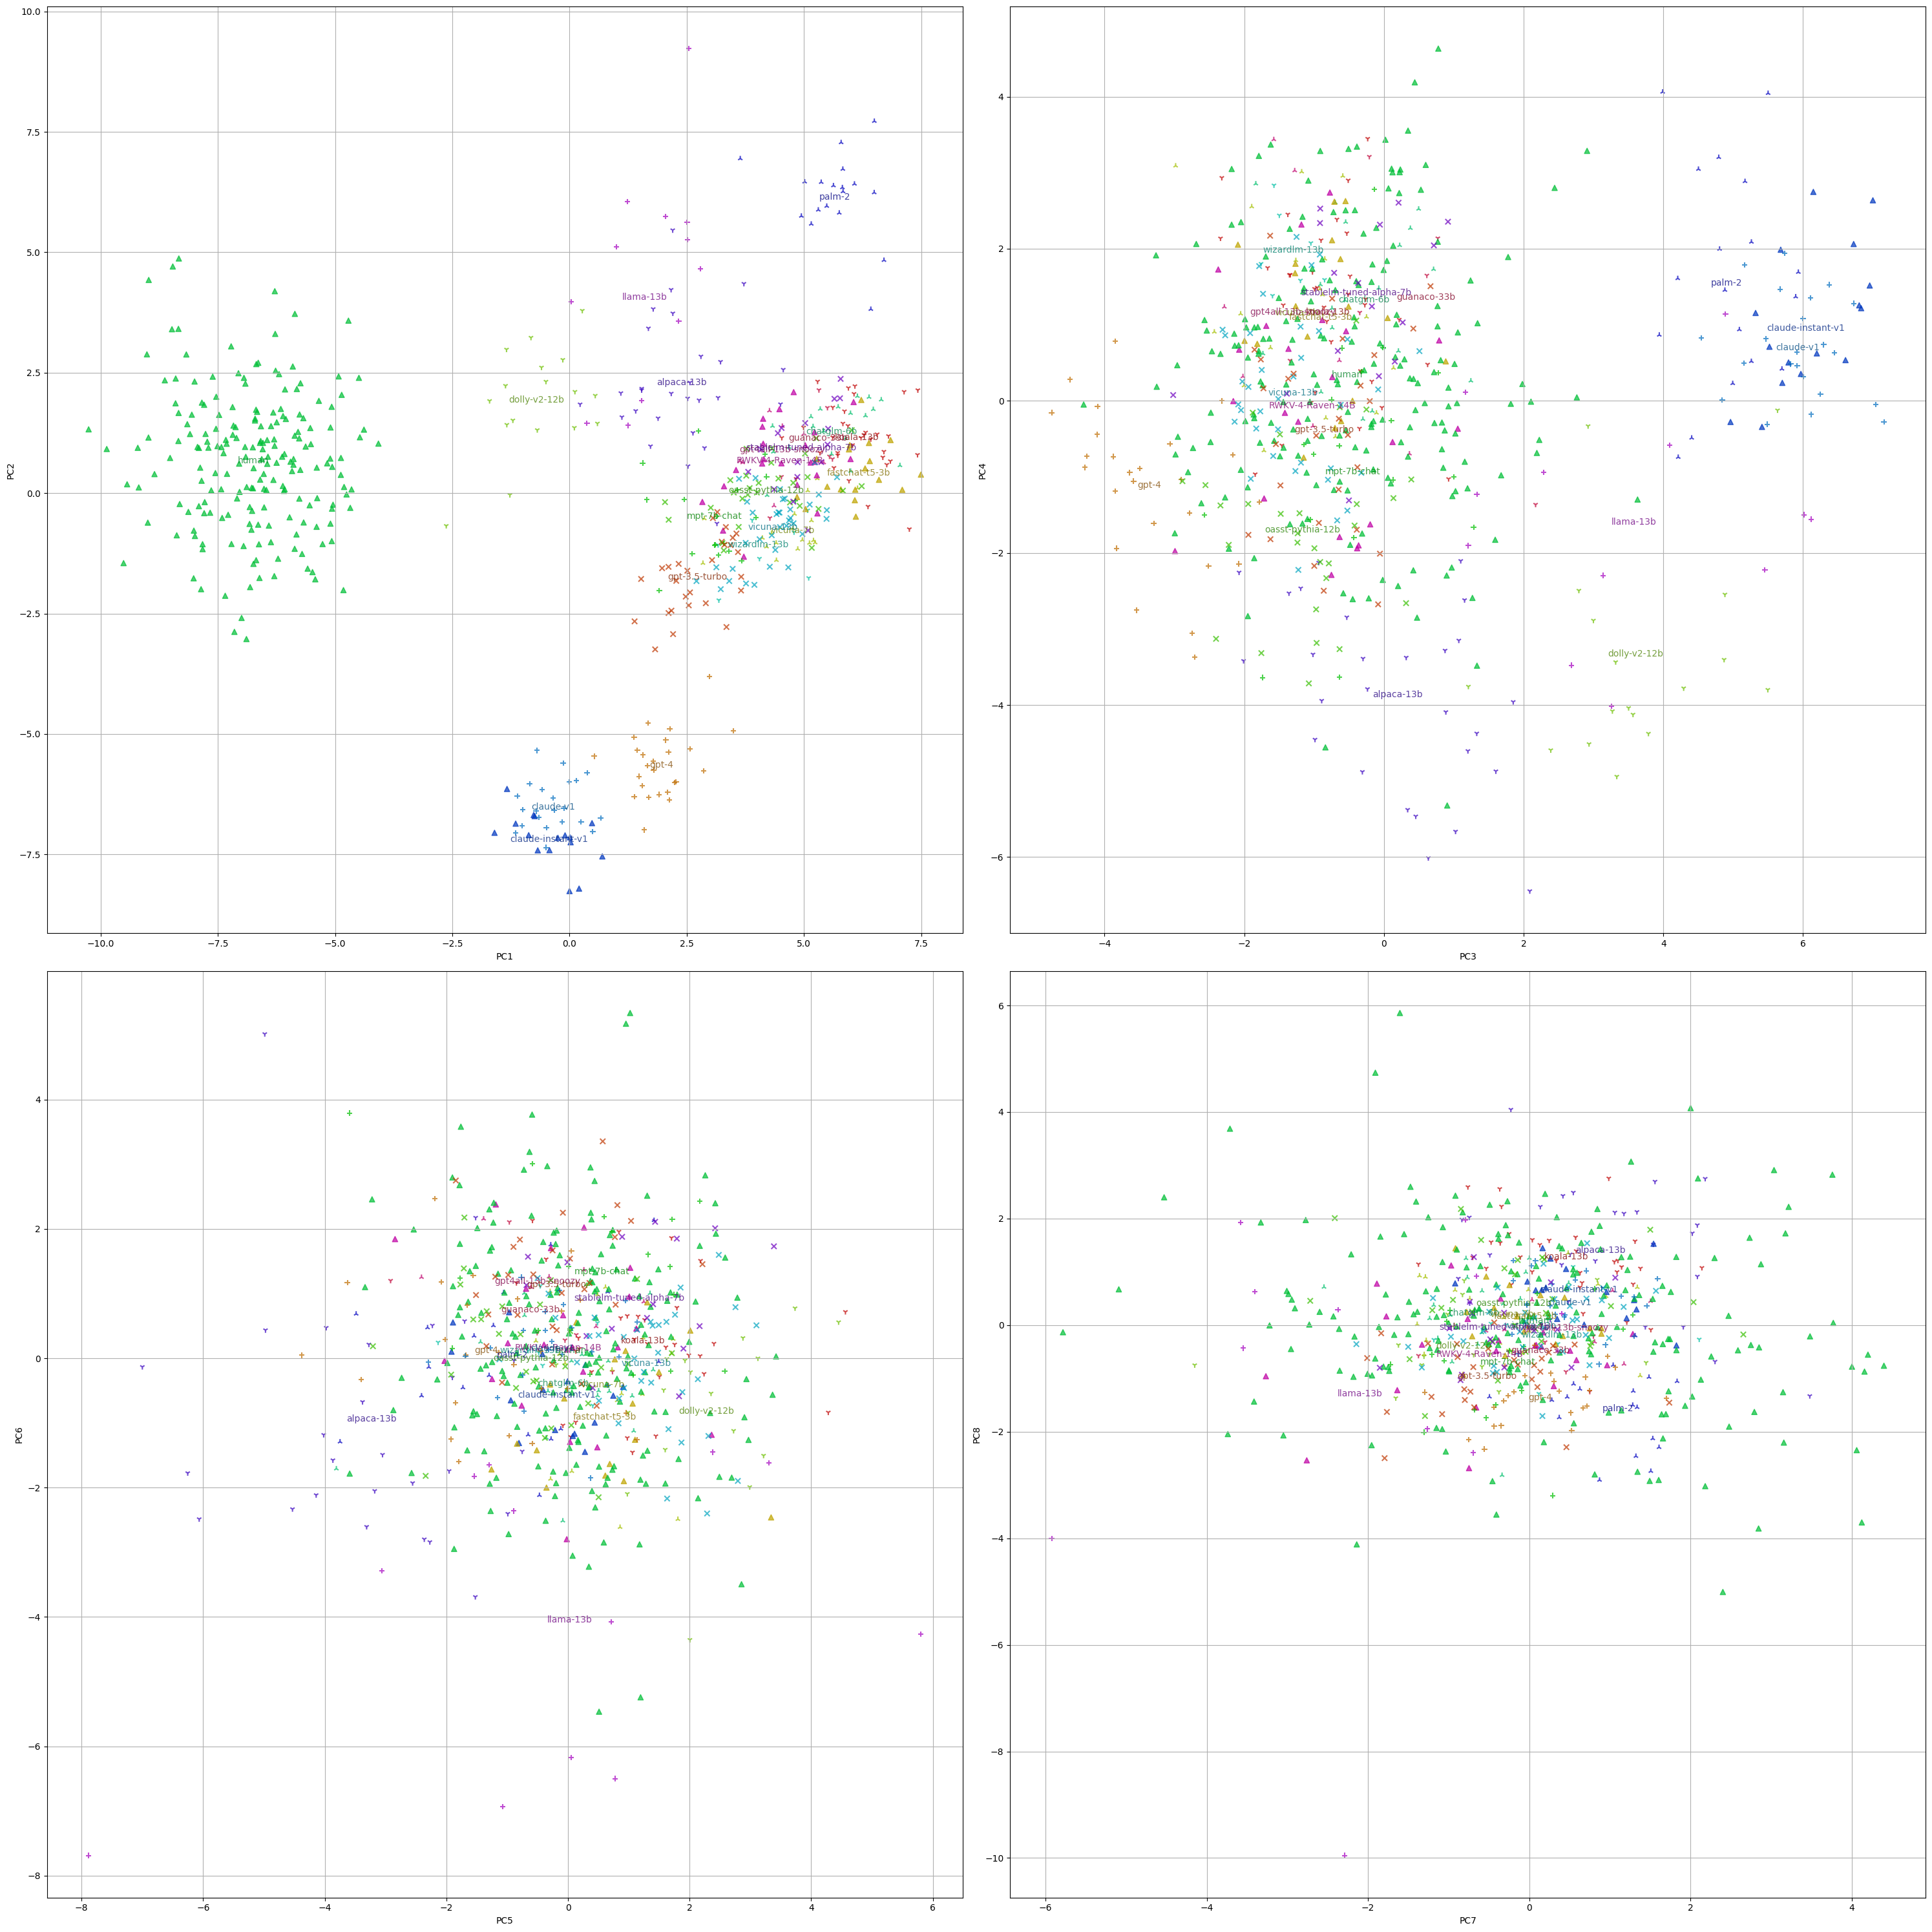

In [25]:
# Define a colour and marker shape for each author using a non-integer index; the integer part determines the shape and the decimal part the colour.
marker_list = {author: i * 5 / len(set(authors)) for i, author in enumerate(list(set(authors)))}

# Plot all training and holdout batches, but in five groups, with a shape for each.
labels = [batch.split('_')[1] for batch in training_dataset] + [batch.split('_')[1] for batch in holdout_dataset]
coords = [transform_to_pc(training_dataset[batch], components) for batch in training_dataset] + [transform_to_pc(holdout_dataset[batch], components) for batch in holdout_dataset]
coord_groups = [[] for i in range(5)]
for i in range(len(labels)) :
    coord_groups[int(marker_list[labels[i]])].append(i)

# Create the scatter plots.
feature_graph_figure = plt.figure(figsize = (30, 30))
feature_graph = feature_graph_figure.subplots(2, 2)
for i in range(4) :
    for group, marker in enumerate(['1', '2', '^', '+', 'x']) :
        feature_graph[int(i / 2)][i % 2].scatter([coords[j][i * 2] for j in coord_groups[group]], [coords[j][i * 2 + 1] for j in coord_groups[group]], color=[colors.hsv_to_rgb((marker_list[labels[j]] % 1, 1, 0.75)) for j in coord_groups[group]], alpha = 0.7, marker = marker)
    for author in list(set(authors)):
        feature_graph[int(i / 2)][i % 2].annotate(author, np.mean([coords[j][i * 2:i * 2 + 2] for j, name in enumerate(training_dataset.columns) if author in name], axis = 0), color = colors.hsv_to_rgb((marker_list[author] % 1, 1, 0.5)), ha = 'center', va = 'center', alpha = 0.75)
    feature_graph[int(i / 2)][i % 2].set_xlabel('PC' + str(i * 2 + 1))
    feature_graph[int(i / 2)][i % 2].set_ylabel('PC' + str(i * 2 + 2))
    feature_graph[int(i / 2)][i % 2].grid(True)
feature_graph_figure.tight_layout()
feature_graph_figure.show()
feature_graph_figure.savefig('images/PCA.png')

### Analysing loadings

In [26]:
for i in range(6) :
    ranking = np.argsort(components[i])
    dimensions = training_dataset.index[ranking]
    weights = components[i][ranking]
    print('\nMost positive PC' + str(i + 1) + ' features:')
    for j in range(5) :
        print(dimensions[-j - 1] + ' ' + str(weights[-j - 1]))
    print('\nMost negative PC' + str(i + 1) + ' features:')
    for j in range(5) :
        print(dimensions[j] + ' ' + str(weights[j]))


Most positive PC1 features:
and 0.17325172079567702
to 0.16117853308049956
 length 0.15742593285575687
such 0.15719136148395538
used 0.1536194777729422

Most negative PC1 features:
me -0.17265407040097283
what -0.17201857770505943
how -0.1658996048018121
answer -0.1492965735323819
do -0.14804151101765858

Most positive PC2 features:
is 0.2727881740563159
you 0.18550391352223886
am 0.16936633208859686
because 0.1628227149670662
it 0.1616228470962853

Most negative PC2 features:
any -0.1625816999123876
like -0.14620248419826762
some -0.1379932883899295
 length -0.12999383554286478
so -0.1145434306494359

Most positive PC3 features:
so 0.26653351600896324
some 0.25778077143363193
but 0.20816664407950541
like 0.20258644456293842
are 0.1981896154241165

Most negative PC3 features:
as -0.14534235312758942
create -0.14099453526269168
which -0.13872446678501205
such -0.13390360219145986
information -0.13210664132412592

Most positive PC4 features:
if 0.230966770535752
this 0.20808474988786793

## k-nearest neighbours

In [27]:
def k_nearest_neighbours(X_train, y_train, X_test, k = 3):
    """
    Predict labels for points in the testing dataset.
    Args:
        X_train (np.ndarray): Points in the training dataset.
        y_train (np.ndarray): Labels in the training dataset.
        X_test (np.ndarray): Points in the testing dataset.
        k (int): The number of nearest neighbours whose label to consider.

    Returns:
        (np.ndarray): List of predicted labels.
    """
    predictions = []

    for test_point in X_test:
        # Compute distances to all training points.
        distances = [np.linalg.norm(train_point - test_point) for train_point in X_train]

        # Determine which points are neighbours.
        k_indices = np.argsort(distances)[:k]
        k_labels = y_train[k_indices]
        # Determine the most common label amongst neighbours.
        unique_labels, counts = np.unique(k_labels, return_counts = True)
        # In the event of tiebreaks, reduce k. At k = 1 a winner is guaranteed.
        while np.count_nonzero(counts == np.max(counts)) != 1 :
            k -= 1
            unique_labels, counts = np.unique(y_train[np.argsort(distances)[:k]], return_counts = True)
        
        predictions.append(unique_labels[np.argmax(counts)])
    
    return np.array(predictions)

### Using k-NN in this run

C:\Users\Homeworkace\AppData\Local\Temp\ipykernel_25380\1084361799.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  prediction_graph_figure.show()


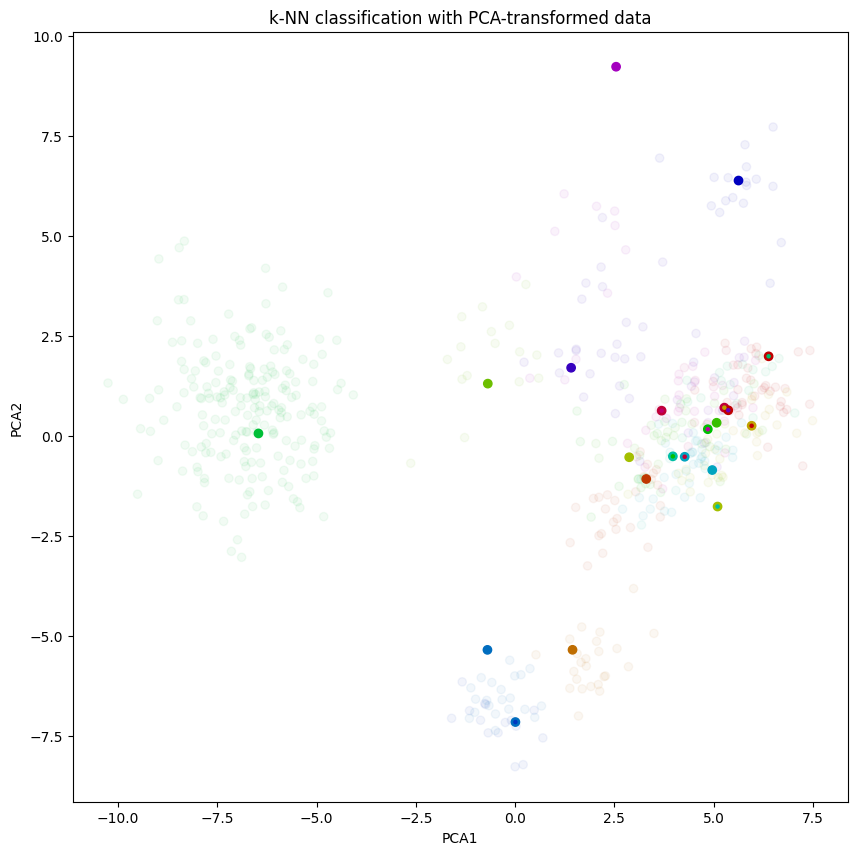

In [28]:
training_batches = np.array([transform_to_pc(training_dataset[batch], components[:10]) for batch in training_dataset])
training_labels = np.array([batch.split('_')[1] for batch in training_dataset])
testing_batches = np.array([transform_to_pc(holdout_dataset[batch], components[:10]) for batch in holdout_dataset])
testing_labels = np.array([batch.split('_')[1] for batch in holdout_dataset])

predictions = k_nearest_neighbours(training_batches, training_labels, testing_batches, 5)

prediction_graph_figure = plt.figure(figsize = (10, 10))
prediction_graph = prediction_graph_figure.subplots()
prediction_graph.scatter([batch[0] for batch in training_batches], [batch[1] for batch in training_batches], color = [colors.hsv_to_rgb((marker_list[batch.split('_')[1]] % 1, 1, 0.75)) for batch in training_dataset], alpha = 0.05)
prediction_graph.scatter([batch[0] for batch in testing_batches], [batch[1] for batch in testing_batches], color = [colors.hsv_to_rgb((marker_list[batch] % 1, 1, 0.75)) for batch in predictions])
prediction_graph.scatter([batch[0] for batch in testing_batches], [batch[1] for batch in testing_batches], color = [colors.hsv_to_rgb((marker_list[batch] % 1, 1, 0.75)) for batch in testing_labels], s = 5)
prediction_graph.set_xlabel('PCA1')
prediction_graph.set_ylabel('PCA2')
prediction_graph.set_title('k-NN classification with PCA-transformed data')
prediction_graph_figure.show()
prediction_graph_figure.savefig('images/k-NN.png')

# Runs across hyperparameters

## Testing regime

In [29]:
def test_suite(hp_n, hp_d, hp_k) :
    """
    Executes multiple test runs to evaluate k-NN performance over the specified range of hyperparameters.
    Args:
        hp_n (int): Seed, or number of test runs.
        hp_d (int): Dimensions, or maximum number of principal components to consider.
        hp_k (int): Maximum k for k-nearest neighbours.
        
    Returns:
        (dict): Predictions indexed by (d, k) pairs, containing results from all runs.
    """
    predictions = {}

    for n in range(hp_n) :
        print('Run #' + str(n + 1) + ', d = ')
        # Perform holdout, feature selection, normalisation and PCA over different seeds.
        training_dataset, holdout_dataset = holdout(batch_dataset, list(set(authors)), n)
        training_dataset, holdout_dataset = common_tokens(training_dataset, holdout_dataset)
        training_dataset, holdout_dataset = centre(training_dataset, holdout_dataset)
        training_dataset, holdout_dataset = standardise(training_dataset, holdout_dataset)
        components, explained_variance = pca_power_iteration(training_dataset, hp_d, 2000, False)

        # Perform PC space projection with an increasing number of the same PCs.
        for d in tqdm(range(1, hp_d + 1)) :
            training_batches = np.array([transform_to_pc(training_dataset[batch], components[:d]) for batch in training_dataset])
            training_labels = np.array([batch.split('_')[1] for batch in training_dataset])
            testing_batches = np.array([transform_to_pc(holdout_dataset[batch], components[:d]) for batch in holdout_dataset])

            # Perform k-NN over all k with the same testing batches.
            for k in range(1, hp_k + 1) :
                if n == 0 :
                    predictions[(d, k)] = k_nearest_neighbours(training_batches, training_labels, testing_batches, k)
                else :
                    predictions[(d, k)] = np.append(predictions[(d, k)], k_nearest_neighbours(training_batches, training_labels, testing_batches, k))
                    
    return predictions

## Confusion matrix and F-score

In [30]:
# Generate predictions.
hp_n = 30
hp_d = 50
hp_k = 15
predictions = test_suite(hp_n, hp_d, hp_k)

evaluation = {}
for (d, k) in predictions :
    result = {}

    # Construct the confusion matrix as a DataFrame.
    result['confusion_matrix'] = pd.crosstab(list(testing_labels) * hp_n, predictions[(d, k)], rownames = ['Actual'])
    result['confusion_matrix'] = result['confusion_matrix'].reindex(columns = result['confusion_matrix'].index.copy(), fill_value = 0) # Recovers columns/prediction labels that were dropped because of being entirely zero.
    result['confusion_matrix'].columns.name = 'Predicted'
    
    precision = []
    recall = []
    f1_score = []
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # Calculate other measurements from the confusion matrix.
    for i in range(result['confusion_matrix'].shape[0]) :
        # Calculate precision.
        if np.sum(result['confusion_matrix'].iloc[:, i]) < 1 :
            precision.append(float(0))
        else :
            precision.append(result['confusion_matrix'].iloc[i, i] / np.sum(result['confusion_matrix'].iloc[:, i]))

        # Calculate recall.
        recall.append(result['confusion_matrix'].iloc[i, i] / np.sum(result['confusion_matrix'].iloc[i, :]))

        # Calculate F_1 score.
        if precision[-1] + recall[-1] == 0 :
            f1_score.append(float(0))
        else :
            f1_score.append(2 * precision[-1] * recall[-1] / (precision[-1] + recall[-1]))

        # Aggregate figures to calculate micro F_1 score.
        true_positives += result['confusion_matrix'].iloc[i, i]
        false_positives += np.sum(result['confusion_matrix'].iloc[:, i]) - result['confusion_matrix'].iloc[i, i]
        false_negatives += np.sum(result['confusion_matrix'].iloc[i, :]) - result['confusion_matrix'].iloc[i, i]

    # Aggregate measurements into a separate DataFrame from the confusion matrix. 
    result['measurements'] = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1_score}, index = result['confusion_matrix'].index)
    
    # Calculate macro F_1.
    result['measurements'] = pd.concat([result['measurements'], pd.DataFrame({
        'precision': np.mean(result['measurements']['precision']),
        'recall': np.mean(result['measurements']['recall']),
        'f1_score': np.mean(result['measurements']['f1_score'])
    }, index = ['Macro'])])
    
    # Calculate micro F_1.
    result['measurements'] = pd.concat([result['measurements'], pd.DataFrame({
        'precision': true_positives / (true_positives + false_positives),
        'recall': true_positives / (true_positives + false_negatives),
        'f1_score': 2 * true_positives / (2 * true_positives + false_positives + false_negatives)
    }, index = ['Micro'])])
    
    evaluation[(d, k)] = result

# Set up a DataFrame for easy visualisation.
list_evaluation = pd.DataFrame({
    'd': [d for _ in range(1, hp_k + 1) for d in range(1, hp_d + 1)],
    'k': [k for k in range(1, hp_k + 1) for _ in range(1, hp_d + 1)],
    'Micro F_1 score': [evaluation[(d, k)]['measurements']['f1_score'][-1] for k in range(1, hp_k + 1) for d in range(1, hp_d + 1)]
})
best_hyperparameters = list_evaluation.sort_values(['Micro F_1 score', 'd', 'k'], ascending = [False, True, True])[:10].copy().reset_index(drop = True)
best_hyperparameters

Run #1, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #2, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #3, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #4, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #5, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #6, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #7, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #8, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #9, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #10, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #11, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #12, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #13, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #14, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #15, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #16, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #17, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #18, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #19, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #20, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #21, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #22, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #23, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #24, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #25, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Run #26, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #27, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #28, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #29, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Run #30, d = 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


,d,k,Micro F_1 score
0,31,8,0.607937
1,31,9,0.606349
2,36,10,0.606349
3,36,9,0.604762
4,29,9,0.603175
5,31,6,0.603175
6,31,7,0.603175
7,34,9,0.603175
8,36,8,0.603175
9,18,7,0.601587


In [31]:
# This cell is to visualise average per-class performance of the best set of hyperparameters.
best_evaluation = evaluation[(best_hyperparameters['d'][0], best_hyperparameters['k'][0])]
best_evaluation['measurements']

,precision,recall,f1_score
RWKV-4-Raven-14B,0.500000,0.100000,0.166667
alpaca-13b,0.781250,0.833333,0.806452
chatglm-6b,0.512821,0.666667,0.579710
claude-instant-v1,1.000000,0.866667,0.928571
claude-v1,0.882353,1.000000,0.937500
dolly-v2-12b,0.896552,0.866667,0.881356
fastchat-t5-3b,0.608696,0.466667,0.528302
gpt-3.5-turbo,0.593750,0.633333,0.612903
gpt-4,1.000000,1.000000,1.000000
gpt4all-13b-snoozy,1.000000,0.566667,0.723404


C:\Users\Homeworkace\AppData\Local\Temp\ipykernel_25380\3531296172.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  confusion_matrix_graph_figure.show()


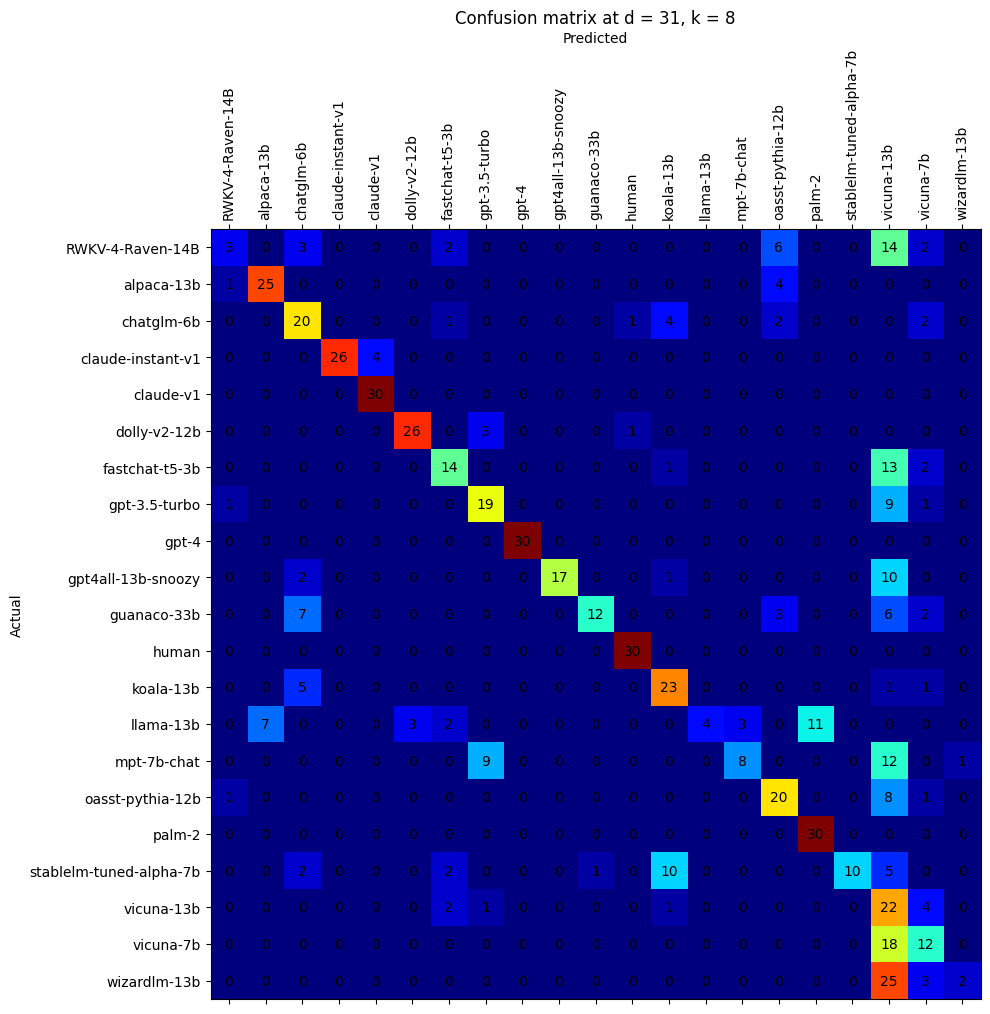

In [32]:
# This cell is to visualise the confusion matrix of the best set of hyperparameters.
labels = best_evaluation['confusion_matrix'].index
predicted_labels = best_evaluation['confusion_matrix'].columns
confusion_matrix_graph_figure = plt.figure(figsize = (12, 10))
confusion_matrix_graph = confusion_matrix_graph_figure.subplots()
confusion_matrix_graph.matshow(best_evaluation['confusion_matrix'], cmap = 'jet')
confusion_matrix_graph.set_xticks(range(len(predicted_labels)))
confusion_matrix_graph.set_xticklabels(predicted_labels, rotation = 90)
confusion_matrix_graph.set_yticks(range(len(labels)))
confusion_matrix_graph.set_yticklabels(labels)
# Add absolute values for each pair.
for i in range(len(labels)):
    for j in range(len(predicted_labels)):
        confusion_matrix_graph.text(j, i, str(best_evaluation['confusion_matrix'].iloc[i, j]), ha = 'center', va = 'center')
confusion_matrix_graph.set_xlabel('Predicted')
confusion_matrix_graph.xaxis.set_label_position('top')
confusion_matrix_graph.set_ylabel('Actual')
confusion_matrix_graph.set_title('Confusion matrix at d = ' + str(best_hyperparameters['d'][0]) + ', k = ' + str(best_hyperparameters['k'][0]))
confusion_matrix_graph_figure.show()
confusion_matrix_graph_figure.savefig('images/confusion matrix.png')

C:\Users\Homeworkace\AppData\Local\Temp\ipykernel_25380\92902236.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hyperparameter_graph_figure.show()


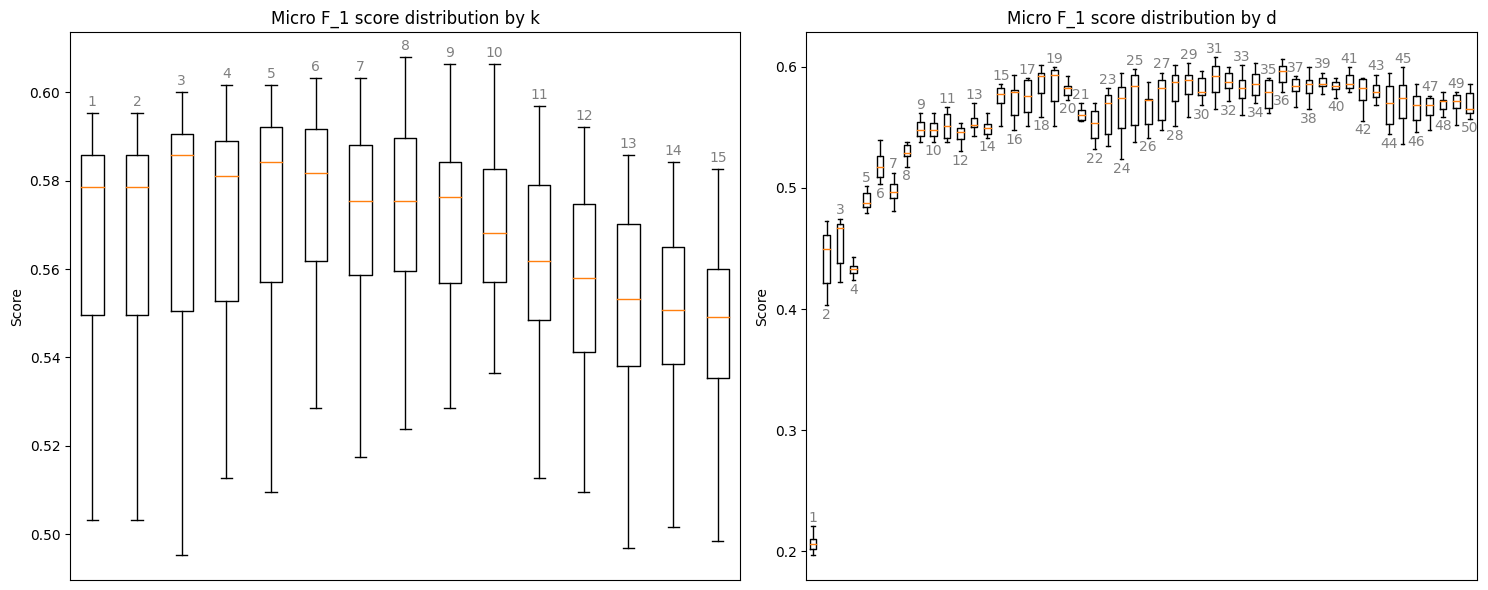

In [33]:
# This cell is to visualise the performance of different values of particular hyperparameters.
hyperparameter_graph_figure = plt.figure(figsize = (15, 6))
hyperparameter_graph = hyperparameter_graph_figure.subplots(1, 2)

# Box plot grouped by k.
f1_by_k = [list_evaluation[list_evaluation['k'] == k]['Micro F_1 score'] for k in sorted(list_evaluation['k'].unique())]
box_k = hyperparameter_graph[0].boxplot(f1_by_k, showfliers = False)
for i in range(0, len(box_k['caps']), 2): # Annotate k near the boxes for ease of reference.
    hyperparameter_graph[0].text(i / 2 + 1, box_k['caps'][i + 1].get_ydata()[0] + 0.001, int(i / 2 + 1), ha = 'center', va = 'bottom', alpha = 0.5)
hyperparameter_graph[0].tick_params(axis = 'x', which = 'both', bottom = False, labelbottom = False)
hyperparameter_graph[0].set_title('Micro F_1 score distribution by k')
hyperparameter_graph[0].set_ylabel('Score')

# Box plot grouped by d.
f1_by_d = [list_evaluation[list_evaluation['d'] == d]['Micro F_1 score'] for d in sorted(list_evaluation['d'].unique())]
box_d = hyperparameter_graph[1].boxplot(f1_by_d, showfliers = False)
for i in range(0, len(box_d['caps']), 2): # Annotate d near the boxes for ease of reference.
    if i % 4 == 0 :
        hyperparameter_graph[1].text(i / 2 + 1, box_d['caps'][i + 1].get_ydata()[0] + 0.001, int(i / 2 + 1), ha = 'center', va = 'bottom', alpha = 0.5)
    else :
        hyperparameter_graph[1].text(i / 2 + 1, box_d['caps'][i].get_ydata()[0] - 0.002, int(i / 2 + 1), ha = 'center', va = 'top', alpha = 0.5)
hyperparameter_graph[1].tick_params(axis = 'x', which = 'both', bottom = False, labelbottom = False)
hyperparameter_graph[1].set_title('Micro F_1 score distribution by d')
hyperparameter_graph[1].set_ylabel('Score')

hyperparameter_graph_figure.tight_layout()
hyperparameter_graph_figure.show()
hyperparameter_graph_figure.savefig('images/hyperparameters.png')